In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%load_ext tensorboard

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import models

2024-10-28 20:32:14.356685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730158334.649829    6939 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730158334.736513    6939 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 20:32:15.332797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cargamos los datos

In [3]:
import pickle
with open("dataset/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("dataset/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)


In [4]:
x_train = np.load("dataset/x_train.npy") #/255.
x_test = np.load("dataset/x_test.npy") #/255.
#y_train_coarse = np.load("dataset/y_train_coarse.npy")
y_train_fine = np.load("dataset/y_train_fine.npy")

In [5]:
y_train_fine.shape

(50000,)

In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train_fine, test_size=0.1, stratify=y_train_fine)

In [17]:
x_val = x_val/np.float16(255.)

In [9]:
y_val.shape

(5000,)

In [10]:
x_val.shape

(5000, 32, 32, 3)

# Data augmentation

In [11]:
x_train_horizontal_flip= x_train[:,:,::-1,:]
x_train_vertical_flip = x_train[:,::-1,:,:]
x_train_vh_flip =x_train[:, ::-1, ::-1, :]

x_train_dup = np.concatenate([x_train,x_train_horizontal_flip,x_train_vertical_flip,x_train_vh_flip],axis=0)
y_train_dup = np.concatenate([y_train, y_train,y_train, y_train], axis=0)

x_train_bis = x_train_dup.copy()
x_train_bis_bis = x_train_dup.copy()


x_train_bis[:,:,1:,:] =x_train_dup[:,:,:-1,:]
x_train_bis_bis[:,:,:-1,:] =x_train_dup[:,:,1:,:]

x_train_dup = np.concatenate([x_train_dup, x_train_bis, x_train_bis_bis],axis=0)
y_train_dup = np.concatenate([y_train_dup, y_train_dup, y_train_dup], axis=0)


In [12]:
print(f'Original dataset size: {len(x_train)}')
print(f'Augmented dataset size: {len(x_train_dup)}')

Original dataset size: 45000
Augmented dataset size: 540000


In [13]:
x_train_dup = x_train_dup/np.float16(255.)

In [14]:
x_train_dup.shape, y_train_dup.shape

((540000, 32, 32, 3), (540000,))

In [15]:
# Define model architecture with many small dense layers and PReLU activation
def create_model(input_shape=(32, 32, 3)):
    # Input layer for images
    inputs = layers.Input(shape=input_shape)
    
    # Flattening layer to convert 3D input to 1D
    x = layers.Flatten()(inputs)
    
    # Many small dense layers with PReLU activation
    x = layers.Dense(128)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(128)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(64)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(32)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(32)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(32)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(16)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(16)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(16)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(8)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(8)(x)
    x = layers.PReLU()(x)
    
    x = layers.Dense(8)(x)
    x = layers.PReLU()(x)
    
    # Parallel output layers for fine and coarse predictions
    fine_output = layers.Dense(100, activation='softmax', name='fine_output')(x)   # Fine-grain prediction
    #coarse_output = layers.Dense(20, activation='softmax', name='coarse_output')(x) # Coarse-grain prediction
    
    # Create model
    model = models.Model(inputs=inputs, outputs=[fine_output])
    
    return model

In [16]:
# Instantiate the model
model = create_model()

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'fine_output': 'sparse_categorical_crossentropy', 
        #'coarse_output': 'sparse_categorical_crossentropy'
    },
    #metrics=['accuracy','accuracy']
    metrics={
        'fine_output': 'accuracy'  # Apply accuracy metric only to the fine output
    }
)

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose= 1)

# rlrop = ReduceLROnPlateau(
#     monitor="val_fine_output_accuracy",  # Monitor fine output validation accuracy
#     factor=0.5,
#     patience=3,
#     verbose=1,
#     min_lr=1e-5
# )
tb = TensorBoard(log_dir="logs")
# Display the model summary
model.summary()

W0000 00:00:1730158590.685971    6939 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 5.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1730158590.697065    6939 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 5.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1730158590.886770    6939 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1750 MB memory:  -> device: 0, name: NVIDIA GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0
2024-10-28 20:36:33.392533: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_NO_BINARY_FOR_GPU'

2024-10-28 20:36:33.392586: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunction

InternalError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:Cast] name: 

In [31]:
# Fit the model
history5 = model.fit(
    x=x_train_dup,                          # Input data (images)
    y={'fine_output': y_train_dup,     # Fine labels target output
       #'coarse_output': y_train_dup[:,0]
       },
    validation_data=(x_val, {'fine_output': y_val}),
    epochs=25,                          # Set your number of epochs
    batch_size=50,                      # Batch size (tune as needed)
    #callbacks=[tb, early_stopping]     
    callbacks=[tb]   # TensorBoard and early stopping callbacks
)

Epoch 1/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.0209 - loss: 4.4213 - val_accuracy: 0.0490 - val_loss: 4.1154
Epoch 2/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.0613 - loss: 4.0380 - val_accuracy: 0.0814 - val_loss: 3.8812
Epoch 3/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.0977 - loss: 3.8221 - val_accuracy: 0.1080 - val_loss: 3.7923
Epoch 4/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1132 - loss: 3.7336 - val_accuracy: 0.1212 - val_loss: 3.7522
Epoch 5/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1284 - loss: 3.6594 - val_accuracy: 0.1208 - val_loss: 3.7150
Epoch 6/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1394 - loss: 3.5951 - val_accuracy: 0.1344 - val_loss: 3.6782
Epoch 7/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1513 - loss: 3.5254 - val_accuracy: 0.1454 - val_loss: 3.6509
Epoch 8/25
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.1658 - loss: 3

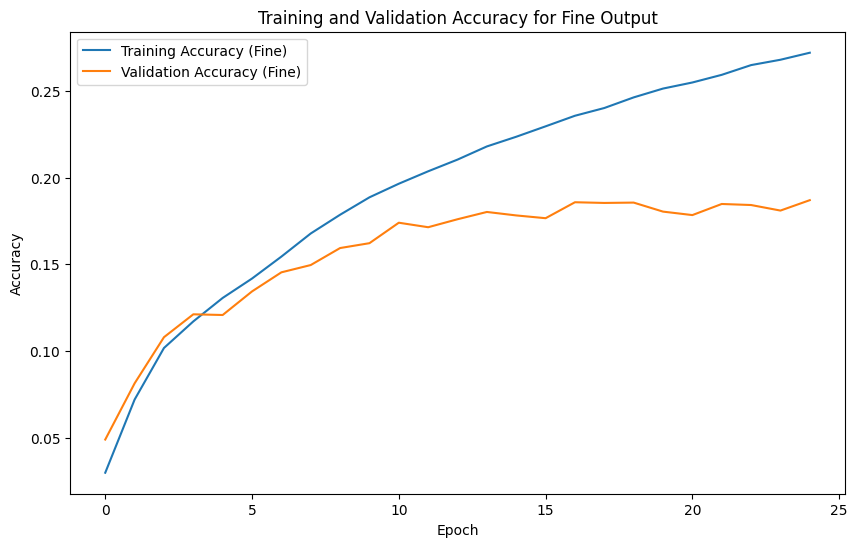

In [35]:
# Plot training and validation accuracy for fine output
plt.figure(figsize=(10, 6))
plt.plot(history5.history['accuracy'], label='Training Accuracy (Fine)')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy (Fine)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Fine Output')
plt.legend()
plt.show()

In [36]:
# Save the model after 25 epochs
model.save("model_prueba.keras")

In [37]:
from tensorflow.keras.models import load_model

In [38]:
# Load the model
trained_model = load_model("model_prueba.keras")

# Continue training for additional epochs
additional_epochs = 50

history5_trained = trained_model.fit(
    x=x_train_dup,                          # Input data (images)
    y={'fine_output': y_train_dup,     # Fine labels target output
       #'coarse_output': y_train_dup[:,0]
       },
    validation_data=(x_val, {'fine_output': y_val}),
    epochs=additional_epochs,                          # Set your number of epochs
    batch_size=50,                      # Batch size (tune as needed)
    #callbacks=[tb, early_stopping]     
    callbacks=[tb]   # TensorBoard and early stopping callbacks
)


Epoch 1/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.2748 - loss: 2.8805 - val_accuracy: 0.1880 - val_loss: 3.7597
Epoch 2/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2796 - loss: 2.8584 - val_accuracy: 0.1874 - val_loss: 3.7576
Epoch 3/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2831 - loss: 2.8428 - val_accuracy: 0.1872 - val_loss: 3.7768
Epoch 4/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2873 - loss: 2.8261 - val_accuracy: 0.1826 - val_loss: 3.8334
Epoch 5/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2901 - loss: 2.8052 - val_accuracy: 0.1912 - val_loss: 3.8081
Epoch 6/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2936 - loss: 2.7872 - val_accuracy: 0.1868 - val_loss: 3.8434
Epoch 7/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.2959 - loss: 2.7797 - val_accuracy: 0.1944 - val_loss: 3.8160
Epoch 8/50
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2977 - loss: 2

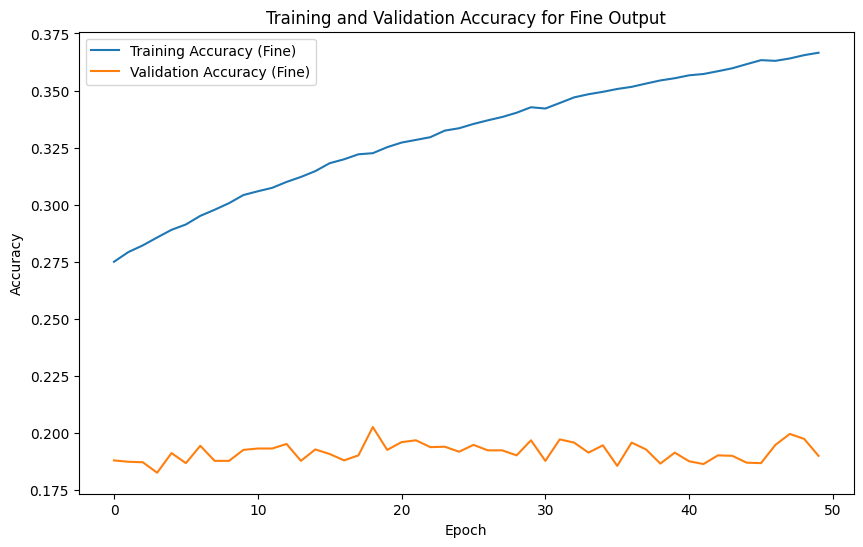

In [39]:
# Plot training and validation accuracy for fine output
plt.figure(figsize=(10, 6))
plt.plot(history5_trained .history['accuracy'], label='Training Accuracy (Fine)')
plt.plot(history5_trained.history['val_accuracy'], label='Validation Accuracy (Fine)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Fine Output')
plt.legend()
plt.show()